**ML PROBLEM 4.2**

**Ideias**

Devemos considerar y e a relação de x para y ao separar os dados. Porque todos os x podem ter a mesma estrutura, mas a diferença apenas estar nos resultados y. Uma vez que o facto de aplicarmos modelos linares diferentes aos dados x, apenas faz variar os valores de y

Para isso podemos tentar usar um clustering que use x e y, dando especial relavância a y. Ou então passar para supervised learning.
(métodos que devem ser adequados K-Means or Gaussian Mixture Models)

No caso de supervised learning, o chatgpt diz dois modelos possiveis:

Multi-Output Regression:
In this approach, you treat the problem as a multi-output regression problem where you predict multiple target values simultaneously. In your case, you can predict both the target values for the first model and the target values for the second model in a single model.
Common algorithms for multi-output regression include MultiOutputRegressor in scikit-learn or using multi-layer neural networks with multiple output nodes.

Multi-Task Learning (MTL):
Multi-task learning is a technique where a single model is trained to perform multiple related tasks. In your case, the tasks are to predict y values for both models.
You can design a neural network architecture where the last layer has two output nodes, one for each model's target values. The earlier layers can capture the shared features between the two models, allowing the model to learn the common underlying structure.
You can use techniques like weight sharing or auxiliary tasks to encourage the model to learn shared representations.



In [1]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import os


**Loading the data from the files given**

In [2]:
# Loading the data from the files given

X_train = np.load(os.path.abspath('X_train_regression2.npy'))
y_train = np.load(os.path.abspath('y_train_regression2.npy'))
X_test  = np.load(os.path.abspath('X_test_regression2.npy'))

**Normalization and Clustering of the data**

Concordo com tentar usar clustering. Podemos tentar usar mais métodos de clustering, mas acho que isso é unsupervised learning. Posso ver se encontro algum método de supervised learning para isso, uma vez que na parte de regressão desta cadeira, estamos a falar de supervised learning e acredito que a maneira de resolver isto seja dentro do pedido na cadeira.

In [5]:
from sklearn import preprocessing
X_train_norm = preprocessing.normalize(X_train) #não sei se concordo - pq temos entradas de dois modelos diferentes



from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)
model1_indices =  [ind for ind, x in enumerate((kmeans.labels_).tolist()) if x == 1]


X_train_model0 = X_train.copy()
X_train_model1 = X_train.copy()
y_train_model0 = y_train.copy()
y_train_model1 = y_train.copy()


X_train_model0 = np.delete(X_train_model0, model1_indices, 0)
y_train_model0 = np.delete(y_train_model0, model1_indices, 0)


X_train_model1 = X_train[model1_indices,:]
y_train_model1 = y_train[model1_indices,:]

<Axes: xlabel='Column3', ylabel='Column4'>

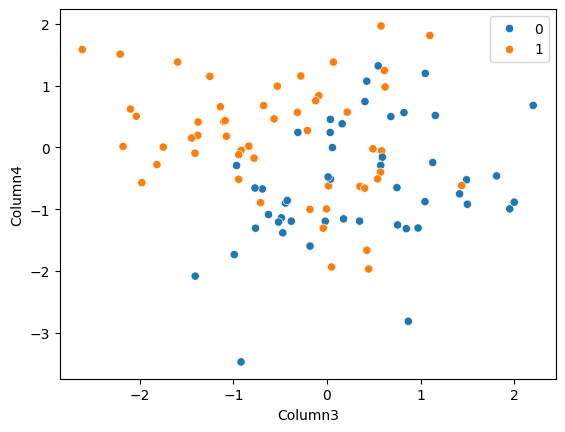

In [7]:
import seaborn as sns
df = pd.DataFrame(X_train, columns=['Column1', 'Column2', 'Column3','Column4'])
sns.scatterplot(data = df, x = 'Column3', y='Column4', hue = kmeans.labels_)

**Predections**

In [ ]:
def prediction_lasso_ridge(x,y, X_test cvLasso, cvRidge):
    X_train_mean  = np.mean(x,axis=0) 
    y_train_mean  = np.mean(y,axis=0)

    X_train_prime = x.copy()
    y_train_prime = y.copy()

    for i in range(x.shape[1]):
        X_train_prime[:,i] = X_train_prime[:,i] -  X_train_mean[i]

    # y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
    y_train_prime = y_train_prime - y_train_mean



    LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=cvLasso,fit_intercept=False,random_state=0).fit(X_train_prime, y_train_prime) 
    beta_hat_lasso  = LassoModelCV.coef_ # Beta Coefficients from the LASSO Regularization


    # Removal of the unnecessary columns from the X data
    X_train_prime_lasso_ridge = X_train_prime.copy()
    X_test_lasso_ridge_model = X_test.copy()
    for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
        if beta_hat_lasso[i]==0:
            X_train_prime_lasso_ridge = np.delete(X_train_prime_lasso_ridge, i, 1)
            X_test_lasso_ridge_model = np.delete(X_test_lasso_ridge_model, i, 1)
            X_train_mean = np.delete(X_train_mean, i, axis = 0)



    RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=cvRidge).fit(X_train_prime_lasso_ridge, y_train_prime)
    beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


    beta_zero_model = y_train_mean - np.matmul((X_train_mean),np.transpose(beta_hat_ridge))
    m = [beta_zero_model[0]]
    for k in range(((beta_hat_ridge).shape[1])):
            m.append(beta_hat_ridge[:,k][0])
    beta_hat_lasso_ridge_model = np.array(m)


    #To calculate a SSE:
    cv_results = cross_validate(RidgeModel, , y,scoring='neg_mean_squared_error', cv=LeaveOneOut())
    neg_mean_squared_errors = cv_results['test_score']
    mean_neg_mean_squared_error = np.mean(neg_mean_squared_errors)

    return X_test_lasso_ridge_model, beta_hat_lasso_ridge_model, mean_neg_mean_squared_error

    


In [ ]:
def Prediction_model(x_test_lasso_ridge, beta_hat_lasso_ridge):
    X_test_final_model = np.hstack((np.ones((1000,1)),x_test_lasso_ridge))
    prediction_model = np.matmul(X_test_final_model,beta_hat_lasso_ridge)
    prediciton_model = prediction_model.reshape(1000,1)
    return prediciton_model

**Prediction for model 0 and 1**

In [ ]:
X_test_lasso_ridge_model0, beta_hat_lasso_ridge_model0, mean_neg_mean_squared_error0 = prediction_lasso_ridge(X_train_model0,y_train_model0, X_test,  8, 5)

X_test_lasso_ridge_model1, beta_hat_lasso_ridge_model1, mean_neg_mean_squared_error1 = prediction_lasso_ridge(X_train_model1,y_train_model1, X_test, 8, 5)

**Prediction on X Test using model 0 and 1**


In [ ]:
prediciton_model0 = Prediction_model(X_test_lasso_ridge_model0, beta_hat_lasso_ridge_model0)

prediciton_model1 = Prediction_model(X_test_lasso_ridge_model1, beta_hat_lasso_ridge_model1)

**Comparison of the predictions given by Model 0 and Model 1**

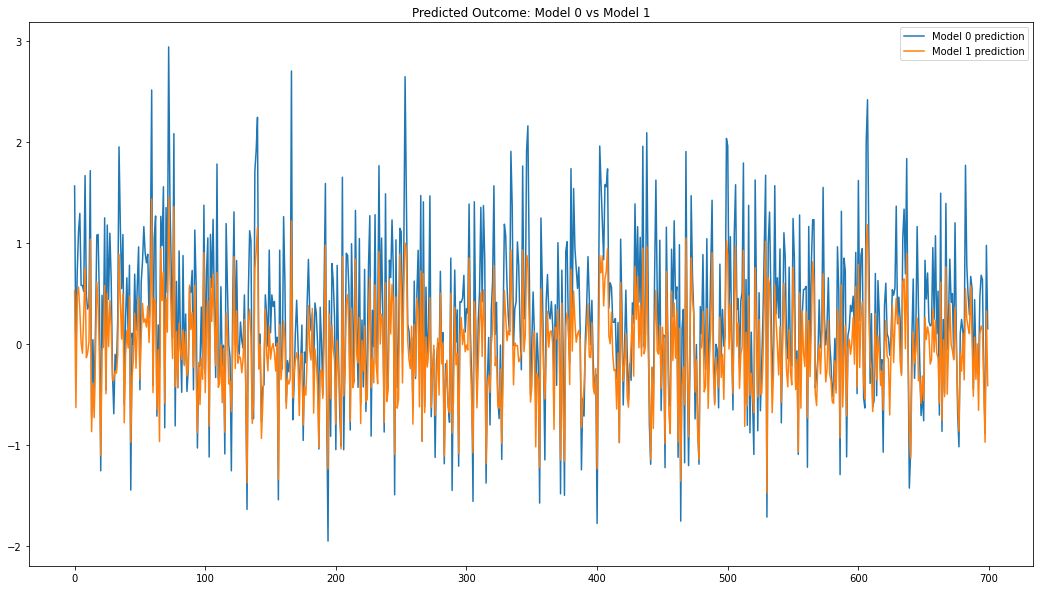

In [ ]:
# Plotting the results
plt.figure(figsize=(18,10))
plt.plot(prediction_model0[0:700],label='Model 0 prediction')
plt.plot(prediction_model1[0:700],label='Model 1 prediction')

plt.title('Predicted Outcome: Model 0 vs Model 1')
plt.legend()

**Merging the two solutions**

In [ ]:
prediction = np.transpose(np.vstack((prediction_model0,prediction_model1)))
#np.save('prediction_100123_100260_4.2',prediction)

[[ 1.56566449  0.52668201]
 [-0.14671722 -0.62974448]
 [ 0.7126349   0.47519721]
 ...
 [-0.01799461 -0.25793792]
 [ 0.912438    0.48612399]
 [ 0.01530982 -0.54662281]]


**Hipoteses para não termos tido mt bom na primeira task**



Ortogonal matching pursuit - experimentar este


In [ ]:
X_train_mean1  = np.mean(X_train_model1,axis=0) 
y_train_mean1  = np.mean(y_train_model1,axis=0)

X_train_prime1= X_train_model1.copy()
y_train_prime1 = y_train_model1.copy()

for i in range(X_train.shape[1]):
    X_train_prime1[:,i] = X_train_prime1[:,i] -  X_train_mean1[i]

# y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
y_train_prime1 = y_train_prime1 - y_train_mean1 



LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=15,fit_intercept=False,random_state=0).fit(X_train_prime1, y_train_prime1) 
LassoModel = Lasso(LassoModelCV.alpha_).fit(X_train_prime1, y_train_prime1) 
beta_hat_lasso  = LassoModel.coef_ # Beta Coefficients from the LASSO Regularization

# Removal of the unnecessary columns from the X data
X_train_prime_lasso_ridge1= X_train_prime1.copy()
X_test_lasso_ridge_model1 = X_test.copy()
for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
    if beta_hat_lasso[i]==0:
        X_train_prime_lasso_ridge1 = np.delete(X_train_prime_lasso_ridge1, i, 1)
        X_test_lasso_ridge_model1 = np.delete(X_test_lasso_ridge_model1, i, 1)
        X_train_mean1 = np.delete(X_train_mean1, i, axis = 0)



RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=5).fit(X_train_prime_lasso_ridge1, y_train_prime1)
beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


beta_zero_model1 = y_train_mean1 - np.matmul((X_train_mean1),np.transpose(beta_hat_ridge))
m = [beta_zero_model1[0]]
for k in range(((beta_hat_ridge).shape[1])):
        m.append(beta_hat_ridge[:,k][0])
beta_hat_lasso_ridge_model1 = np.array(m)



c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.828057096981222, tolerance: 0.007202391301952269
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Prog

In [ ]:
X_train_mean0  = np.mean(X_train_model0,axis=0) 
y_train_mean0  = np.mean(y_train_model0,axis=0)

X_train_prime0 = X_train_model0.copy()
y_train_prime0 = y_train_model0.copy()

for i in range(X_train.shape[1]):
    X_train_prime0[:,i] = X_train_prime0[:,i] -  X_train_mean0[i]

# y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
y_train_prime0 = y_train_prime0 - y_train_mean0 



LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=8,fit_intercept=False,random_state=0).fit(X_train_prime0, y_train_prime0) 
LassoModel = Lasso(LassoModelCV.alpha_).fit(X_train_prime0, y_train_prime0) 
beta_hat_lasso  = LassoModel.coef_ # Beta Coefficients from the LASSO Regularization


# Removal of the unnecessary columns from the X data
X_train_prime_lasso_ridge0 = X_train_prime0.copy()
X_test_lasso_ridge_model0 = X_test.copy()
for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
    if beta_hat_lasso[i]==0:
        X_train_prime_lasso_ridge0 = np.delete(X_train_prime_lasso_ridge0, i, 1)
        X_test_lasso_ridge_model0 = np.delete(X_test_lasso_ridge_model0, i, 1)
        X_train_mean0 = np.delete(X_train_mean0, i, axis = 0)



RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=5).fit(X_train_prime_lasso_ridge0, y_train_prime0)
beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


beta_zero_model0 = y_train_mean0 - np.matmul((X_train_mean0),np.transpose(beta_hat_ridge))
m = [beta_zero_model0[0]]
for k in range(((beta_hat_ridge).shape[1])):
        m.append(beta_hat_ridge[:,k][0])
beta_hat_lasso_ridge_model0 = np.array(m)

 


c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.56817040280928, tolerance: 0.0074324537585645275
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\rodol\AppData\Local\Prog

In [ ]:
X_test_final_model1 = np.hstack((np.ones((1000,1)),X_test_lasso_ridge_model1))
prediction_model1 = np.matmul(X_test_final_model1,beta_hat_lasso_ridge_model1)
prediciton_model1 = prediction_model1.reshape(1000,1)